## Set-up

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from io import open
import glob
import os
import time

import numpy as np


In [2]:
# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cpu


## Prepare and load Data

In [3]:
import string
import unicodedata

allowed_characters = string.ascii_letters + " .,;'"
n_letters = len(allowed_characters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [4]:
%run -i 'pytorch_example/namesdataset.py'

-- Initiate Dataset declaration
-- Dataset declaration finalized


In [5]:
alldata = NamesDataset("data/names")
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 20074 items of data
example = (tensor([10]), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]]), 'Czech', 'Abl')


In [6]:
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 17063, validation examples = 3011


## Prepare model

In [7]:
%run -i 'pytorch_example/rnn.py'

-- Initiate model and training declaration
-- Finished model and training declaration


In [8]:
n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq))
print(rnn)

CharRNN(
  (rnn): RNN(57, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [9]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

In [10]:
print('Pre-training sample output:')
input = lineToTensor('Albert')
output = rnn(input) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_uniq))

Pre-training sample output:
tensor([[-2.8375, -2.9054, -2.9356, -2.8871, -2.8837, -2.7876, -2.8398, -2.8769,
         -2.9188, -2.8548, -3.0424, -2.8581, -2.7847, -3.0709, -2.9118, -2.8235,
         -2.8564, -3.0042]], grad_fn=<LogSoftmaxBackward0>)
('Italian', 12)


In [11]:
start = time.time()
all_losses = train(rnn, train_set, n_epoch=27, learning_rate=0.15, report_every=5)
end = time.time()
print(f"training took {end-start}s")

training on data set with n = 17063
5 (19%): 	 average batch loss = 0.8822229283575794
10 (37%): 	 average batch loss = 0.6909087871353774
15 (56%): 	 average batch loss = 0.5730189291744167
20 (74%): 	 average batch loss = 0.48643401906006317
25 (93%): 	 average batch loss = 0.4305525833838864
training took 294.8509202003479s


In [12]:
print('Post-training sample output:')

input = lineToTensor('Albert')
output = rnn(input) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_uniq))

Post-training sample output:
tensor([[ -9.4392, -13.1396, -14.3706, -14.8097,  -7.2653,  -1.3769, -13.9304,
          -7.5366,  -3.3570, -16.6157,  -3.9247,  -3.0438,  -3.4867, -15.7960,
          -8.7421,  -0.9774,  -2.7326,  -1.7604]],
       grad_fn=<LogSoftmaxBackward0>)
('German', 15)


In [13]:
all_losses = np.array(all_losses)
all_losses

array([1.37807297, 1.09325524, 1.00291767, 0.94106882, 0.88222293,
       0.83552222, 0.78946692, 0.75365768, 0.71440688, 0.69090879,
       0.65584501, 0.63648235, 0.61407448, 0.59208054, 0.57301893,
       0.55544386, 0.53507791, 0.52050265, 0.50522156, 0.48643402,
       0.47708821, 0.46291662, 0.45404715, 0.44144533, 0.43055258,
       0.42145732, 0.41240176])

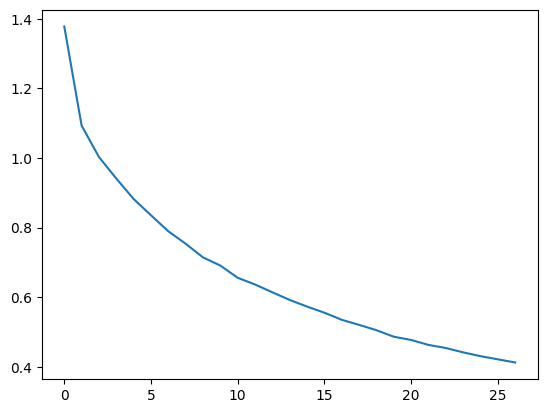

In [16]:
plt.figure()
plt.plot(all_losses)
plt.show()

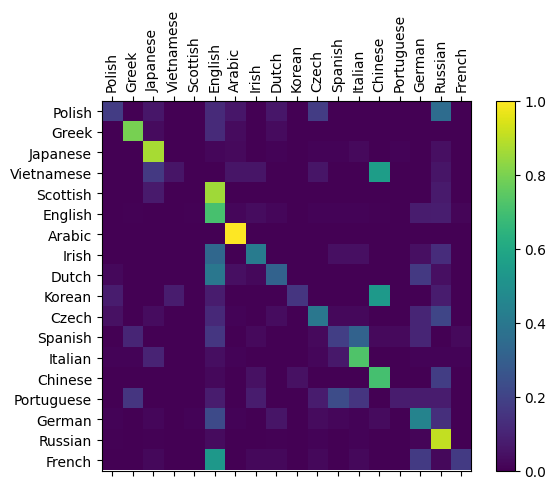

In [17]:
evaluate(rnn, test_set, classes=alldata.labels_uniq)